# Предсказание оттока клиентов банка

## 1. Установка и импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
import os
import time
import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (
    SelectKBest, f_classif, RFE, SelectFromModel, mutual_info_classif
)

import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score,
    accuracy_score, precision_score, recall_score,
    ConfusionMatrixDisplay, auc
)

import xgboost as xgb
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import shap
import sklearn

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

In [2]:
print(" Все библиотеки успешно импортированы!")
print(f" Python: {sys.version.split()[0]}")
print(f" pandas: {pd.__version__}, numpy: {np.__version__}")
print(f" sklearn: {sklearn.__version__}, xgboost: {xgb.__version__}")

benchmark_results = {}

 Все библиотеки успешно импортированы!
 Python: 3.10.15
 pandas: 2.2.3, numpy: 1.26.4
 sklearn: 1.5.2, xgboost: 1.7.6


## 2. Загрузка и первичный осмотр данных

In [3]:
df = pd.read_csv('TZ.csv')

print(f" Размер датасета: {df.shape[0]} строк × {df.shape[1]} столбцов")
print(f"\n Столбцы: {list(df.columns)}")
print(f"\n{'='*60}")
print("Первые 5 строк:")
df.head()

 Размер датасета: 15000 строк × 14 столбцов

 Столбцы: ['ID', 'ID_клиента', 'фамилия', 'кредитный_рейтинг', 'город', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'ушел_из_банка']

Первые 5 строк:


,ID,ID_клиента,фамилия,кредитный_рейтинг,город,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
0,0,15709511.0,Тестов55,754.0,Астана,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Тестов539,579.0,Алматы,Female,28.0,1.0,NaN,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Тестов275,744.0,Алматы,Female,56.0,5.0,NaN,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Есенгельдиев,697.0,Алматы,Male,29.0,2.0,NaN,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Тестов451,628.0,Алматы,Female,22.0,9.0,NaN,2.0,1.0,0.0,49653.39,0.0


In [4]:
print(" Типы данных и пропуски:")
print("="*60)
df.info()

 Типы данных и пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  15000 non-null  int64  
 1   ID_клиента          15000 non-null  float64
 2   фамилия             15000 non-null  object 
 3   кредитный_рейтинг   15000 non-null  float64
 4   город               15000 non-null  object 
 5   пол                 15000 non-null  object 
 6   возраст             15000 non-null  float64
 7   стаж_в_банке        15000 non-null  float64
 8   баланс_депозита     5316 non-null   float64
 9   число_продуктов     15000 non-null  float64
 10  есть_кредитка       15000 non-null  float64
 11  активный_клиент     15000 non-null  float64
 12  оценочная_зарплата  15000 non-null  float64
 13  ушел_из_банка       15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [5]:
print(f"\n Описательная статистика:")
df.describe()


 Описательная статистика:


,ID,ID_клиента,кредитный_рейтинг,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,5316.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
mean,7499.500000,1.579653e+07,658.851467,37.888000,5.033333,121681.886227,1.590733,0.783200,0.500200,1.181348e+05,0.203867
std,4330.271354,1.270937e+07,72.587026,8.257409,2.808359,22875.768239,0.535587,0.412079,0.500017,4.680311e+04,0.402884
min,0.000000,1.556578e+07,431.000000,18.000000,0.000000,753.370000,1.000000,0.000000,0.000000,1.158000e+01,0.000000
25%,3749.750000,1.563449e+07,602.000000,32.000000,3.000000,106392.525000,1.000000,1.000000,0.000000,8.362960e+04,0.000000
50%,7499.500000,1.569053e+07,662.000000,37.000000,5.000000,122570.690000,2.000000,1.000000,1.000000,1.235878e+05,0.000000
75%,11249.250000,1.575758e+07,709.000000,42.000000,7.000000,137226.870000,2.000000,1.000000,1.000000,1.575585e+05,0.000000
max,14999.000000,1.572242e+09,850.000000,74.000000,10.000000,187530.660000,4.000000,1.000000,1.000000,1.557802e+06,1.000000


In [6]:
print(f" Дубликаты: {df.duplicated().sum()}")
print(f"\n Распределение целевой переменной 'ушел_из_банка':")
print(df['ушел_из_банка'].value_counts())
print(f"\n В процентах:")
print(df['ушел_из_банка'].value_counts(normalize=True).round(4) * 100)

 Дубликаты: 0

 Распределение целевой переменной 'ушел_из_банка':
ушел_из_банка
0.0    11942
1.0     3058
Name: count, dtype: int64

 В процентах:
ушел_из_банка
0.0    79.61
1.0    20.39
Name: proportion, dtype: float64


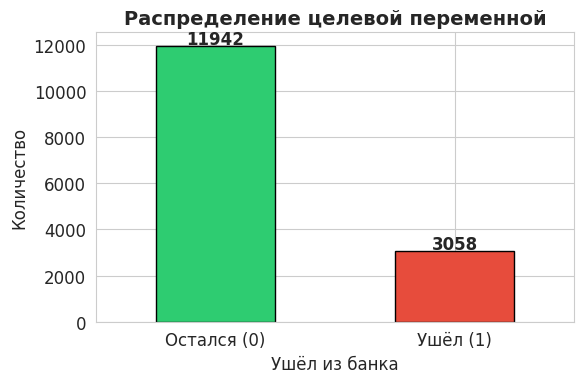

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
colors = ['#2ecc71', '#e74c3c']
df['ушел_из_банка'].value_counts().plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Распределение целевой переменной', fontsize=14, fontweight='bold')
ax.set_xlabel('Ушёл из банка')
ax.set_ylabel('Количество')
ax.set_xticklabels(['Остался (0)', 'Ушёл (1)'], rotation=0)
for i, v in enumerate(df['ушел_из_банка'].value_counts()):
    ax.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Разведочный анализ данных (EDA)

Числовые признаки

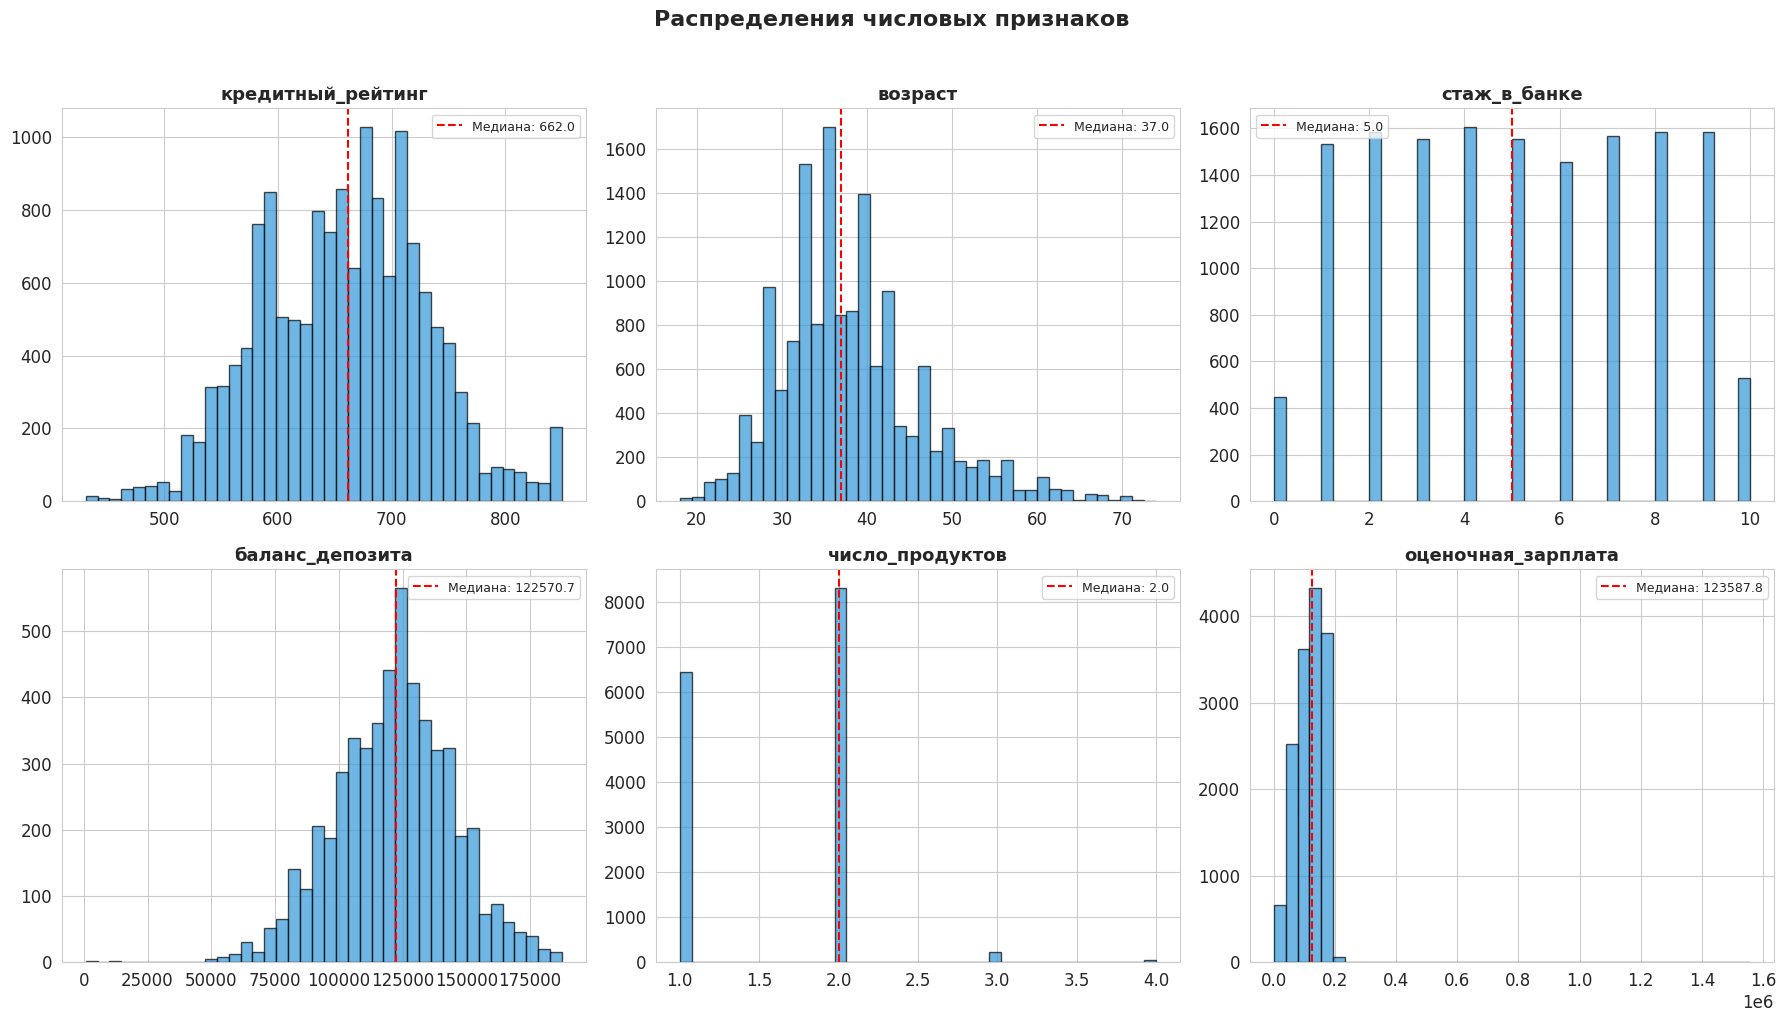

In [8]:
num_cols = ['кредитный_рейтинг', 'возраст', 'стаж_в_банке', 'баланс_депозита',
            'число_продуктов', 'оценочная_зарплата']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=40, color='#3498db', edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=13, fontweight='bold')
    axes[i].axvline(df[col].median(), color='red', linestyle='--', label=f'Медиана: {df[col].median():.1f}')
    axes[i].legend(fontsize=9)
plt.suptitle('Распределения числовых признаков', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Категориальные признаки — countplot

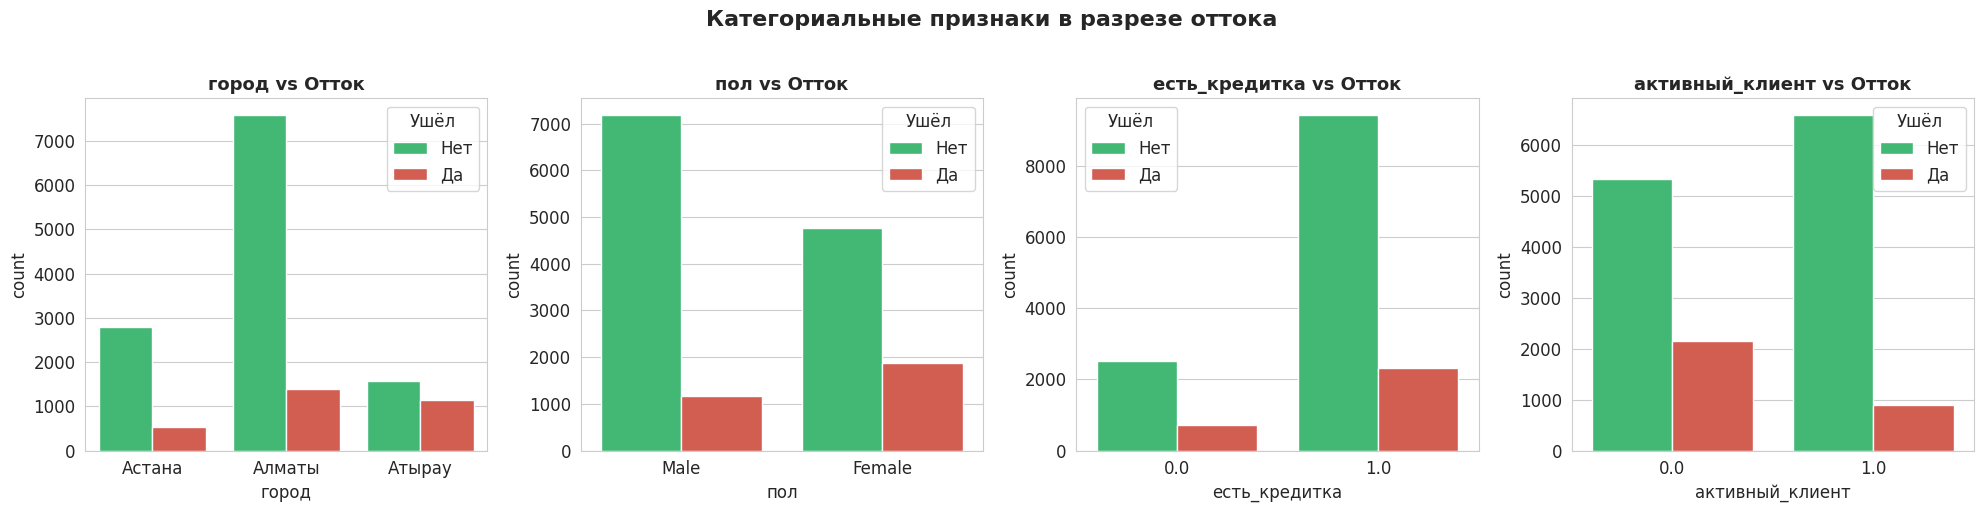

In [9]:
cat_cols = ['город', 'пол', 'есть_кредитка', 'активный_клиент']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue='ушел_из_банка', palette=['#2ecc71', '#e74c3c'], ax=axes[i])
    axes[i].set_title(f'{col} vs Отток', fontsize=13, fontweight='bold')
    axes[i].legend(title='Ушёл', labels=['Нет', 'Да'])
plt.suptitle('Категориальные признаки в разрезе оттока', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Корреляционная матрица

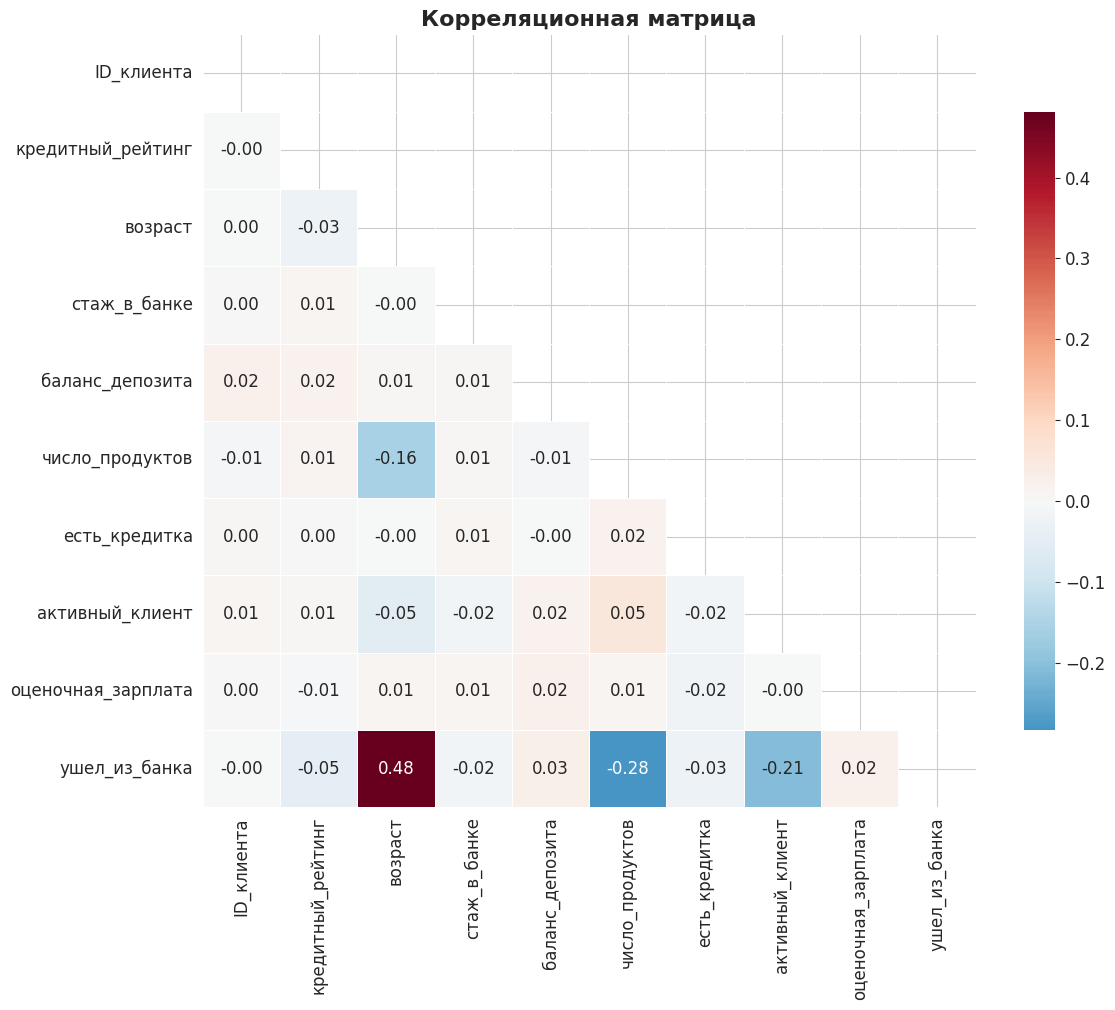

In [10]:
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['ID'], errors='ignore')
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Корреляционная матрица', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Boxplot числовых признаков в разрезе целевой переменной

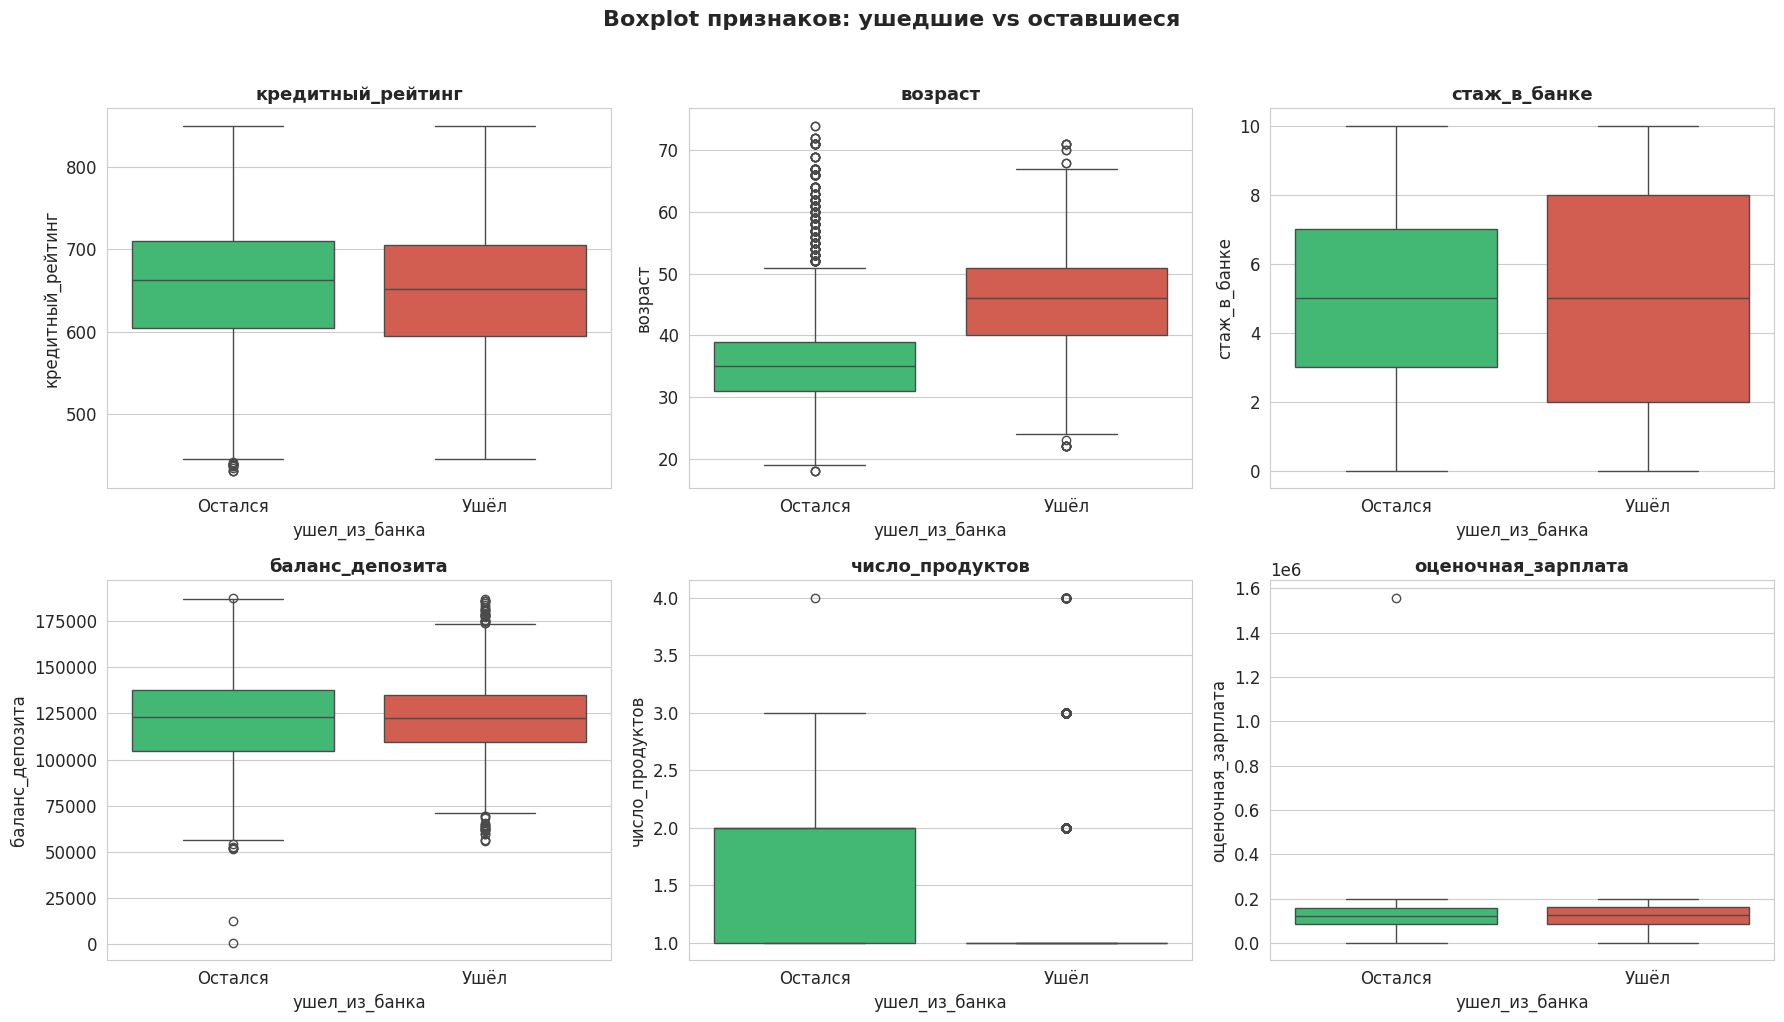

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='ушел_из_банка', y=col, palette=['#2ecc71', '#e74c3c'], ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=13, fontweight='bold')
    axes[i].set_xticklabels(['Остался', 'Ушёл'])
plt.suptitle('Boxplot признаков: ушедшие vs оставшиеся', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Статистика по группам

In [12]:
print(" Средние значения признаков по группам (ушедшие vs оставшиеся):")
print("="*70)
group_stats = df.groupby('ушел_из_банка')[num_cols].mean().T
group_stats.columns = ['Остался (0)', 'Ушёл (1)']
group_stats['Разница, %'] = ((group_stats['Ушёл (1)'] - group_stats['Остался (0)']) / group_stats['Остался (0)'] * 100).round(1)
group_stats

 Средние значения признаков по группам (ушедшие vs оставшиеся):


,Остался (0),Ушёл (1),"Разница, %"
кредитный_рейтинг,660.519176,652.338784,-1.2
возраст,35.876654,45.742642,27.5
стаж_в_банке,5.054681,4.949967,-2.1
баланс_депозита,121241.753977,122769.998942,1.3
число_продуктов,1.667225,1.292021,-22.5
оценочная_зарплата,117578.002658,120309.327541,2.3


## 4. Обработка пропущенных значений

Анализ пропусков

In [13]:
print(" Количество пропусков по каждому столбцу:")
print("="*50)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Пропуски': missing, 'Процент': missing_pct})
missing_df = missing_df[missing_df['Пропуски'] > 0].sort_values('Пропуски', ascending=False)
print(missing_df)

 Количество пропусков по каждому столбцу:
                 Пропуски  Процент
баланс_депозита      9684    64.56


Давайте теперь заполним пропуски медианой, так как она устойчива к выбросам.

In [14]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  {col}: заполнено медианой = {median_val:.2f}")
        else:
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"  {col}: заполнено модой = {mode_val}")

  баланс_депозита: заполнено медианой = 122570.69


In [15]:
print(f"\n Пропуски после обработки: {df.isnull().sum().sum()}")
print(f" Итоговый размер: {df.shape}")


 Пропуски после обработки: 0
 Итоговый размер: (15000, 14)


## 5. Преобразование категориальных признаков

Удаляем неинформативные столбцы

In [16]:
drop_cols = ['ID', 'ID_клиента', 'фамилия']
df_clean = df.drop(columns=drop_cols, errors='ignore')
print(f" Удалены столбцы: {drop_cols}")

 Удалены столбцы: ['ID', 'ID_клиента', 'фамилия']


Кодирование бинарного признака 'пол'

In [17]:
le_gender = LabelEncoder()
df_clean['пол'] = le_gender.fit_transform(df_clean['пол'])  # Female=0, Male=1
print(f" 'пол' закодирован: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

 'пол' закодирован: {'Female': 0, 'Male': 1}


One-Hot Encoding для 'город'

In [18]:
df_clean = pd.get_dummies(df_clean, columns=['город'], prefix='город', drop_first=False)
for col in df_clean.columns:
    if df_clean[col].dtype == bool:
        df_clean[col] = df_clean[col].astype(int)

In [19]:
print(f"\n Итоговые столбцы ({len(df_clean.columns)}):")
print(list(df_clean.columns))
print(f"\n Форма: {df_clean.shape}")


 Итоговые столбцы (13):
['кредитный_рейтинг', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'ушел_из_банка', 'город_Алматы', 'город_Астана', 'город_Атырау']

 Форма: (15000, 13)


In [20]:
df_clean.head()

,кредитный_рейтинг,пол,возраст,стаж_в_банке,баланс_депозита,число_продуктов,есть_кредитка,активный_клиент,оценочная_зарплата,ушел_из_банка,город_Алматы,город_Астана,город_Атырау
0,754.0,1,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0,0,1,0
1,579.0,0,28.0,1.0,122570.69,2.0,1.0,0.0,64869.32,0.0,1,0,0
2,744.0,0,56.0,5.0,122570.69,1.0,1.0,0.0,158816.03,1.0,1,0,0
3,697.0,1,29.0,2.0,122570.69,2.0,1.0,0.0,55775.72,0.0,1,0,0
4,628.0,0,22.0,9.0,122570.69,2.0,1.0,0.0,49653.39,0.0,1,0,0


## 6. Анализ и обработка дисбаланса классов

Давайте попробуем анализировать дисбаланс

In [21]:
target = 'ушел_из_банка'
class_counts = df_clean[target].value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]
print(f" Соотношение классов: {class_counts[0]} (0) vs {class_counts[1]} (1)")
print(f" Imbalance ratio: {imbalance_ratio:.2f}:1")

 Соотношение классов: 11942 (0) vs 3058 (1)
 Imbalance ratio: 3.91:1


Разделение X и y

In [22]:
X = df_clean.drop(columns=[target])
y = df_clean[target].astype(int)

Сохраним список признаков

In [23]:
feature_names = list(X.columns)
print(f"\n Признаки для модели ({len(feature_names)}): {feature_names}")


 Признаки для модели (12): ['кредитный_рейтинг', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата', 'город_Алматы', 'город_Астана', 'город_Атырау']


## 7. Разделение на обучающую и тестовую выборки

Разделение данных

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f" Обучающая выборка: {X_train.shape} | Распределение: {dict(y_train.value_counts())}")
print(f" Тестовая выборка:  {X_test.shape}  | Распределение: {dict(y_test.value_counts())}")

 Обучающая выборка: (12000, 12) | Распределение: {0: 9554, 1: 2446}
 Тестовая выборка:  (3000, 12)  | Распределение: {0: 2388, 1: 612}


SMOTE для обучающей выборки

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"\n После SMOTE (train): {X_train_smote.shape}")
print(f"   Распределение: {dict(pd.Series(y_train_smote).value_counts())}")


 После SMOTE (train): (19108, 12)
   Распределение: {0: 9554, 1: 9554}


## 8. Масштабирование признаков

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [27]:
X_train_tree = X_train_smote.values if hasattr(X_train_smote, 'values') else X_train_smote
X_test_tree = X_test.values if hasattr(X_test, 'values') else X_test
y_train_tree = y_train_smote.values if hasattr(y_train_smote, 'values') else y_train_smote

print(" Масштабирование выполнено (StandardScaler)")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")

 Масштабирование выполнено (StandardScaler)
   X_train_scaled: (19108, 12)
   X_test_scaled: (3000, 12)


## 8.1 Feature Selection (Отбор признаков)

Давай отбор признаков сделаем по несколько методами

### SelectKBest с f_classif (ANOVA F-value)

In [28]:
selector_kbest = SelectKBest(score_func=f_classif, k='all')
selector_kbest.fit(X_train_smote, y_train_smote)
kbest_scores = pd.DataFrame({
    'Признак': feature_names,
    'F-score': selector_kbest.scores_,
    'p-value': selector_kbest.pvalues_
}).sort_values('F-score', ascending=False)

print("\n SelectKBest (ANOVA F-value):")
print(kbest_scores.to_string(index=False))


 SelectKBest (ANOVA F-value):
           Признак     F-score       p-value
           возраст 9966.047547  0.000000e+00
               пол 3614.239268  0.000000e+00
   число_продуктов 2158.116997  0.000000e+00
      город_Алматы 2046.481792  0.000000e+00
   активный_клиент 1538.040159 1.482197e-323
      город_Астана 1020.670947 3.088945e-218
      город_Атырау  643.417671 1.227091e-139
 кредитный_рейтинг   65.178572  7.243304e-16
оценочная_зарплата   16.548609  4.760906e-05
     есть_кредитка   13.963733  1.869138e-04
   баланс_депозита   12.013059  5.294511e-04
      стаж_в_банке    5.427884  1.982804e-02


### Mutual Information

In [29]:
 mi_scores = mutual_info_classif(X_train_smote, y_train_smote, random_state=42)
mi_df = pd.DataFrame({
    'Признак': feature_names,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

print("\n Mutual Information:")
print(mi_df.to_string(index=False))


 Mutual Information:
           Признак  MI Score
           возраст  0.447970
 кредитный_рейтинг  0.321197
      стаж_в_банке  0.315130
   число_продуктов  0.290707
   активный_клиент  0.176396
оценочная_зарплата  0.142830
     есть_кредитка  0.110550
               пол  0.085038
   баланс_депозита  0.059174
      город_Алматы  0.045931
      город_Астана  0.026688
      город_Атырау  0.018325


### Feature Importance из Random Forest

In [30]:
rf_quick = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_quick.fit(X_train_smote, y_train_smote)
rf_imp_df = pd.DataFrame({
    'Признак': feature_names,
    'RF Importance': rf_quick.feature_importances_
}).sort_values('RF Importance', ascending=False)

print("\n Random Forest Feature Importance:")
print(rf_imp_df.to_string(index=False))


 Random Forest Feature Importance:
           Признак  RF Importance
           возраст       0.328799
   число_продуктов       0.276822
   активный_клиент       0.136641
               пол       0.080068
      город_Алматы       0.040294
      город_Астана       0.028669
   баланс_депозита       0.028328
     есть_кредитка       0.020884
оценочная_зарплата       0.017550
 кредитный_рейтинг       0.017181
      стаж_в_банке       0.012480
      город_Атырау       0.012284


Давайте попробуем объединить рейтинг признаков

In [31]:
combined_rank = pd.DataFrame({'Признак': feature_names})
combined_rank['Rank_KBest'] = kbest_scores.reset_index(drop=True).index + 1
combined_rank['Rank_MI'] = mi_df.reset_index(drop=True).index + 1
combined_rank['Rank_RF'] = rf_imp_df.reset_index(drop=True).index + 1

In [32]:
combined_rank = combined_rank.set_index('Признак')
combined_rank = combined_rank.loc[feature_names].reset_index()

In [33]:
for feat in feature_names:
    combined_rank.loc[combined_rank['Признак'] == feat, 'Rank_KBest'] = \
        kbest_scores[kbest_scores['Признак'] == feat].index[0] + 1
    combined_rank.loc[combined_rank['Признак'] == feat, 'Rank_MI'] = \
        mi_df[mi_df['Признак'] == feat].index[0] + 1
    combined_rank.loc[combined_rank['Признак'] == feat, 'Rank_RF'] = \
        rf_imp_df[rf_imp_df['Признак'] == feat].index[0] + 1

In [34]:
combined_rank['Avg_Rank'] = combined_rank[['Rank_KBest', 'Rank_MI', 'Rank_RF']].mean(axis=1)
combined_rank = combined_rank.sort_values('Avg_Rank')

In [35]:
print("\n Объединённый рейтинг признаков:")
print(combined_rank.to_string(index=False))


 Объединённый рейтинг признаков:
           Признак  Rank_KBest  Rank_MI  Rank_RF  Avg_Rank
 кредитный_рейтинг           1        1        1       1.0
               пол           2        2        2       2.0
           возраст           3        3        3       3.0
      стаж_в_банке           4        4        4       4.0
   баланс_депозита           5        5        5       5.0
   число_продуктов           6        6        6       6.0
     есть_кредитка           7        7        7       7.0
   активный_клиент           8        8        8       8.0
оценочная_зарплата           9        9        9       9.0
      город_Алматы          10       10       10      10.0
      город_Астана          11       11       11      11.0
      город_Атырау          12       12       12      12.0


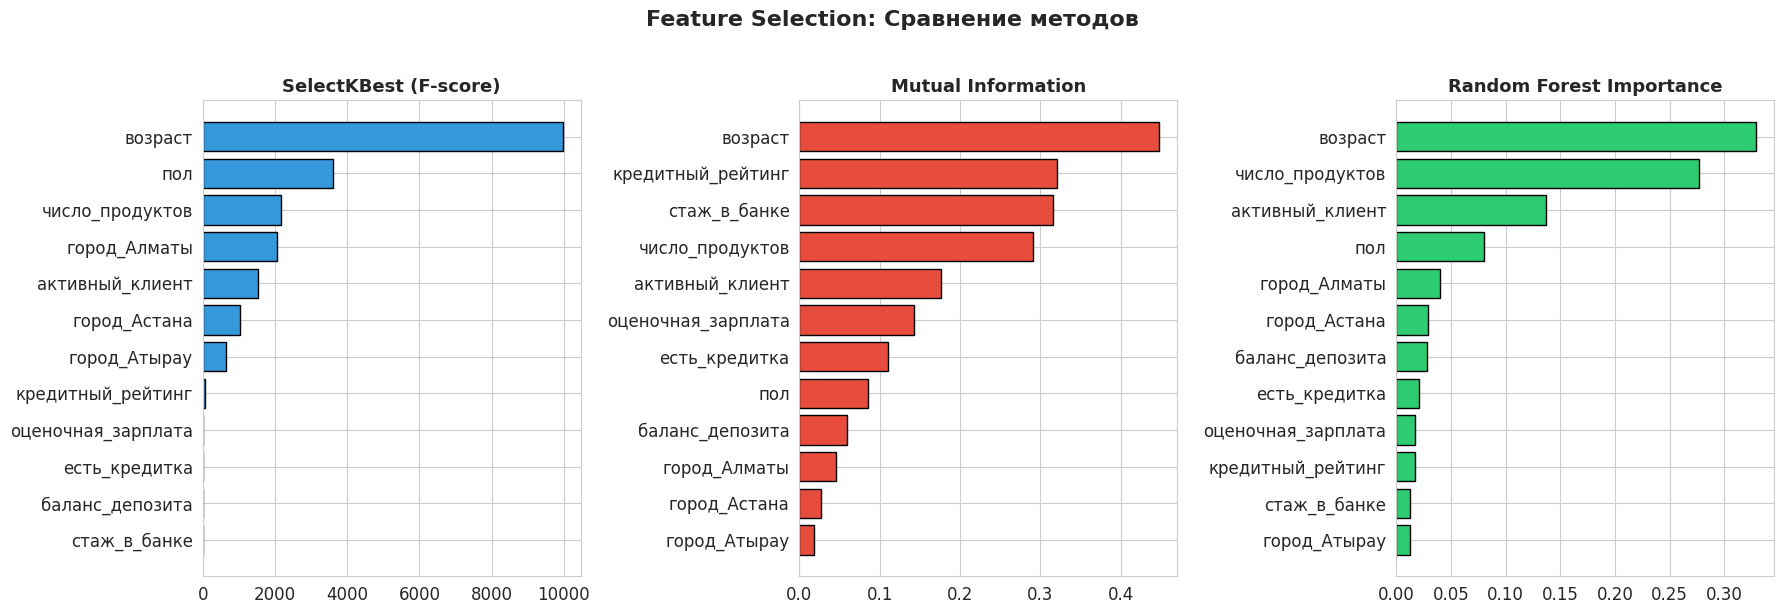

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

kbest_plot = kbest_scores.sort_values('F-score', ascending=True)
axes[0].barh(kbest_plot['Признак'], kbest_plot['F-score'], color='#3498db', edgecolor='black')
axes[0].set_title('SelectKBest (F-score)', fontsize=13, fontweight='bold')

mi_plot = mi_df.sort_values('MI Score', ascending=True)
axes[1].barh(mi_plot['Признак'], mi_plot['MI Score'], color='#e74c3c', edgecolor='black')
axes[1].set_title('Mutual Information', fontsize=13, fontweight='bold')

rf_plot = rf_imp_df.sort_values('RF Importance', ascending=True)
axes[2].barh(rf_plot['Признак'], rf_plot['RF Importance'], color='#2ecc71', edgecolor='black')
axes[2].set_title('Random Forest Importance', fontsize=13, fontweight='bold')

plt.suptitle('Feature Selection: Сравнение методов', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [37]:
n_features_keep = int(len(feature_names) * 0.75)
selected_features = combined_rank.head(n_features_keep)['Признак'].tolist()
print(f"\n Отобрано {len(selected_features)} из {len(feature_names)} признаков:")
print(f"   {selected_features}")


 Отобрано 9 из 12 признаков:
   ['кредитный_рейтинг', 'пол', 'возраст', 'стаж_в_банке', 'баланс_депозита', 'число_продуктов', 'есть_кредитка', 'активный_клиент', 'оценочная_зарплата']


In [38]:
USE_FEATURE_SELECTION = False

if USE_FEATURE_SELECTION:
    feature_mask = [f in selected_features for f in feature_names]
    X_train_tree = X_train_smote.iloc[:, feature_mask] if hasattr(X_train_smote, 'iloc') else X_train_smote[:, feature_mask]
    X_test_tree = X_test.iloc[:, feature_mask] if hasattr(X_test, 'iloc') else X_test[:, feature_mask]
    X_train_scaled = scaler.fit_transform(X_train_tree)
    X_test_scaled = scaler.transform(X_test_tree)
    feature_names = selected_features
    print(f"\n Feature Selection активирован. Используются {len(feature_names)} признаков.")
else:
    print(f"\n Feature Selection отключен. Используются все {len(feature_names)} признаков.")


 Feature Selection отключен. Используются все 12 признаков.


In [39]:
def evaluate_model(name, model, X_tr, X_te, y_tr, y_te, benchmark_dict):
    """Обучает модель, считает метрики и сохраняет в бенчмарк."""
    start = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start

    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    roc = roc_auc_score(y_te, y_proba)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    benchmark_dict[name] = {
        'model': model,
        'ROC-AUC': round(roc, 4),
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-score': round(f1, 4),
        'Время (сек)': round(train_time, 2),
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    print(f"{'='*60}")
    print(f" {name}")
    print(f"{'='*60}")
    print(f"  ROC-AUC:   {roc:.4f}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Время:     {train_time:.2f} сек")
    print(f"\n{classification_report(y_te, y_pred, target_names=['Остался', 'Ушёл'])}")
    return model

## 9. Обучение Logistic Regression

In [40]:
lr_model = evaluate_model(
    'Logistic Regression',
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    X_train_scaled, X_test_scaled, y_train_smote, y_test,
    benchmark_results
)

 Logistic Regression
  ROC-AUC:   0.8778
  Accuracy:  0.8423
  Precision: 0.5975
  Recall:    0.6961
  F1-score:  0.6430
  Время:     0.52 сек

              precision    recall  f1-score   support

     Остался       0.92      0.88      0.90      2388
        Ушёл       0.60      0.70      0.64       612

    accuracy                           0.84      3000
   macro avg       0.76      0.79      0.77      3000
weighted avg       0.85      0.84      0.85      3000



## 10. Обучение Random Forest

In [41]:
rf_model = evaluate_model(
    'Random Forest',
    RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced',
                           random_state=42, n_jobs=-1),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Random Forest
  ROC-AUC:   0.9258
  Accuracy:  0.8917
  Precision: 0.7504
  Recall:    0.7026
  F1-score:  0.7257
  Время:     0.30 сек

              precision    recall  f1-score   support

     Остался       0.93      0.94      0.93      2388
        Ушёл       0.75      0.70      0.73       612

    accuracy                           0.89      3000
   macro avg       0.84      0.82      0.83      3000
weighted avg       0.89      0.89      0.89      3000



## 11. Обучение XGBoost

Использую `scale_pos_weight` для учёта дисбаланса (на оригинальных данных)

In [42]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos

xgb_model = evaluate_model(
    'XGBoost',
    xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        scale_pos_weight=spw, eval_metric='logloss',
        random_state=42, n_jobs=-1, use_label_encoder=False,
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 XGBoost
  ROC-AUC:   0.9279
  Accuracy:  0.8690
  Precision: 0.6395
  Recall:    0.8203
  F1-score:  0.7187
  Время:     18.62 сек

              precision    recall  f1-score   support

     Остался       0.95      0.88      0.91      2388
        Ушёл       0.64      0.82      0.72       612

    accuracy                           0.87      3000
   macro avg       0.79      0.85      0.82      3000
weighted avg       0.89      0.87      0.87      3000



## 12. Обучение CatBoost

In [43]:
cb_model = evaluate_model(
    'CatBoost',
    CatBoostClassifier(
        iterations=500, depth=6, learning_rate=0.1,
        auto_class_weights='Balanced', verbose=0, random_state=42
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 CatBoost
  ROC-AUC:   0.9310
  Accuracy:  0.8943
  Precision: 0.7697
  Recall:    0.6879
  F1-score:  0.7265
  Время:     1.99 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.77      0.69      0.73       612

    accuracy                           0.89      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.89      0.89      0.89      3000



## 13. Обучение ансамблевых методов (Bagging, AdaBoost, GradientBoosting, Voting, Stacking)

In [44]:
bag_model = evaluate_model(
    'Bagging (DT)',
    BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=15),
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Bagging (DT)
  ROC-AUC:   0.9175
  Accuracy:  0.8870
  Precision: 0.7399
  Recall:    0.6879
  F1-score:  0.7130
  Время:     1.85 сек

              precision    recall  f1-score   support

     Остался       0.92      0.94      0.93      2388
        Ушёл       0.74      0.69      0.71       612

    accuracy                           0.89      3000
   macro avg       0.83      0.81      0.82      3000
weighted avg       0.88      0.89      0.89      3000



In [45]:
ada_model = evaluate_model(
    'AdaBoost',
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=200, learning_rate=0.1, random_state=42
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 AdaBoost
  ROC-AUC:   0.9212
  Accuracy:  0.8947
  Precision: 0.7803
  Recall:    0.6732
  F1-score:  0.7228
  Время:     5.90 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.78      0.67      0.72       612

    accuracy                           0.89      3000
   macro avg       0.85      0.81      0.83      3000
weighted avg       0.89      0.89      0.89      3000



In [46]:
gb_model = evaluate_model(
    'Gradient Boosting',
    GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Gradient Boosting
  ROC-AUC:   0.9323
  Accuracy:  0.8957
  Precision: 0.7618
  Recall:    0.7108
  F1-score:  0.7354
  Время:     7.55 сек

              precision    recall  f1-score   support

     Остался       0.93      0.94      0.94      2388
        Ушёл       0.76      0.71      0.74       612

    accuracy                           0.90      3000
   macro avg       0.84      0.83      0.84      3000
weighted avg       0.89      0.90      0.89      3000



In [47]:
voting_model = evaluate_model(
    'Voting (RF+XGB+CB)',
    VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                       eval_metric='logloss', random_state=42, use_label_encoder=False)),
            ('cb', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0, random_state=42))
        ],
        voting='soft'
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Voting (RF+XGB+CB)
  ROC-AUC:   0.9322
  Accuracy:  0.8950
  Precision: 0.7676
  Recall:    0.6961
  F1-score:  0.7301
  Время:     22.27 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.77      0.70      0.73       612

    accuracy                           0.90      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.89      0.90      0.89      3000



In [48]:
stacking_model = evaluate_model(
    'Stacking (RF+XGB+CB → LR)',
    StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)),
            ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                       eval_metric='logloss', random_state=42)),
            ('cb', CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_state=42))
        ],
        final_estimator=LogisticRegression(max_iter=1000),
        cv=5, n_jobs=-1
    ),
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Stacking (RF+XGB+CB → LR)
  ROC-AUC:   0.9304
  Accuracy:  0.8890
  Precision: 0.7276
  Recall:    0.7288
  F1-score:  0.7282
  Время:     6.51 сек

              precision    recall  f1-score   support

     Остался       0.93      0.93      0.93      2388
        Ушёл       0.73      0.73      0.73       612

    accuracy                           0.89      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.89      0.89      0.89      3000



## 14. Подбор гиперпараметров лучших моделей (GridSearchCV)

In [49]:
bench_df_temp = pd.DataFrame({
    name: {k: v for k, v in metrics.items() if k not in ['model', 'y_pred', 'y_proba']}
    for name, metrics in benchmark_results.items()
}).T.sort_values('ROC-AUC', ascending=False)

print(" Текущий бенчмарк (топ-5 по ROC-AUC):")
print(bench_df_temp.head())
top_models = bench_df_temp.index[:3].tolist()
print(f"\n Модели для тюнинга: {top_models}")

 Текущий бенчмарк (топ-5 по ROC-AUC):
                           ROC-AUC  Accuracy  Precision  Recall  F1-score  \
Gradient Boosting           0.9323    0.8957     0.7618  0.7108    0.7354   
Voting (RF+XGB+CB)          0.9322    0.8950     0.7676  0.6961    0.7301   
CatBoost                    0.9310    0.8943     0.7697  0.6879    0.7265   
Stacking (RF+XGB+CB → LR)   0.9304    0.8890     0.7276  0.7288    0.7282   
XGBoost                     0.9279    0.8690     0.6395  0.8203    0.7187   

                           Время (сек)  
Gradient Boosting                 7.55  
Voting (RF+XGB+CB)               22.27  
CatBoost                          1.99  
Stacking (RF+XGB+CB → LR)         6.51  
XGBoost                          18.62  

 Модели для тюнинга: ['Gradient Boosting', 'Voting (RF+XGB+CB)', 'CatBoost']


In [50]:
print(" Подбор гиперпараметров XGBoost...")
xgb_params = {
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    xgb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0
)

start = time.time()
xgb_grid.fit(X_train_tree, y_train_tree)
xgb_tune_time = time.time() - start

print(f" Лучшие параметры: {xgb_grid.best_params_}")
print(f" Лучший ROC-AUC (CV): {xgb_grid.best_score_:.4f}")
print(f" Время: {xgb_tune_time:.1f} сек")

evaluate_model(
    'XGBoost (tuned)',
    xgb_grid.best_estimator_,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Подбор гиперпараметров XGBoost...
 Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
 Лучший ROC-AUC (CV): 0.9810
 Время: 43.8 сек
 XGBoost (tuned)
  ROC-AUC:   0.9325
  Accuracy:  0.8950
  Precision: 0.7725
  Recall:    0.6879
  F1-score:  0.7277
  Время:     6.88 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.77      0.69      0.73       612

    accuracy                           0.90      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.89      0.90      0.89      3000



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [51]:
print(" Подбор гиперпараметров Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    rf_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0
)

start = time.time()
rf_grid.fit(X_train_tree, y_train_tree)
rf_tune_time = time.time() - start

print(f" Лучшие параметры: {rf_grid.best_params_}")
print(f" Лучший ROC-AUC (CV): {rf_grid.best_score_:.4f}")
print(f" Время: {rf_tune_time:.1f} сек")

evaluate_model(
    'Random Forest (tuned)',
    rf_grid.best_estimator_,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Подбор гиперпараметров Random Forest...
 Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 Лучший ROC-AUC (CV): 0.9813
 Время: 29.3 сек
 Random Forest (tuned)
  ROC-AUC:   0.9256
  Accuracy:  0.8883
  Precision: 0.7417
  Recall:    0.6944
  F1-score:  0.7173
  Время:     0.42 сек

              precision    recall  f1-score   support

     Остался       0.92      0.94      0.93      2388
        Ушёл       0.74      0.69      0.72       612

    accuracy                           0.89      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.89      0.89      0.89      3000



RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [52]:
print(" Подбор гиперпараметров CatBoost...")
cb_params = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cb_grid = GridSearchCV(
    CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42),
    cb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0
)

start = time.time()
cb_grid.fit(X_train_tree, y_train_tree)
cb_tune_time = time.time() - start

print(f" Лучшие параметры: {cb_grid.best_params_}")
print(f" Лучший ROC-AUC (CV): {cb_grid.best_score_:.4f}")
print(f" Время: {cb_tune_time:.1f} сек")

evaluate_model(
    'CatBoost (tuned)',
    cb_grid.best_estimator_,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Подбор гиперпараметров CatBoost...
 Лучшие параметры: {'depth': 10, 'iterations': 700, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
 Лучший ROC-AUC (CV): 0.9811
 Время: 529.7 сек
 CatBoost (tuned)
  ROC-AUC:   0.9270
  Accuracy:  0.8957
  Precision: 0.7713
  Recall:    0.6944
  F1-score:  0.7309
  Время:     12.86 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.94      2388
        Ушёл       0.77      0.69      0.73       612

    accuracy                           0.90      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.89      0.90      0.89      3000



In [53]:
print(" Подбор гиперпараметров Gradient Boosting...")
gb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0
)

start = time.time()
gb_grid.fit(X_train_tree, y_train_tree)
gb_tune_time = time.time() - start

print(f" Лучшие параметры: {gb_grid.best_params_}")
print(f" Лучший ROC-AUC (CV): {gb_grid.best_score_:.4f}")
print(f" Время: {gb_tune_time:.1f} сек")

evaluate_model(
    'Gradient Boosting (tuned)',
    gb_grid.best_estimator_,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Подбор гиперпараметров Gradient Boosting...
 Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}
 Лучший ROC-AUC (CV): 0.9813
 Время: 312.2 сек
 Gradient Boosting (tuned)
  ROC-AUC:   0.9289
  Accuracy:  0.8907
  Precision: 0.7601
  Recall:    0.6781
  F1-score:  0.7168
  Время:     16.56 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.76      0.68      0.72       612

    accuracy                           0.89      3000
   macro avg       0.84      0.81      0.82      3000
weighted avg       0.89      0.89      0.89      3000



GradientBoostingClassifier(learning_rate=0.05, max_depth=9,
                           min_samples_split=10, n_estimators=300,
                           random_state=42, subsample=0.8)

In [54]:
print(" Создание улучшенного Voting Classifier с оптимизированными моделями...")

voting_tuned = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_),
        ('cb', cb_grid.best_estimator_),
        ('gb', gb_grid.best_estimator_)
    ],
    voting='soft'
)

evaluate_model(
    'Voting (tuned RF+XGB+CB+GB)',
    voting_tuned,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Создание улучшенного Voting Classifier с оптимизированными моделями...
 Voting (tuned RF+XGB+CB+GB)
  ROC-AUC:   0.9317
  Accuracy:  0.8950
  Precision: 0.7685
  Recall:    0.6944
  F1-score:  0.7296
  Время:     35.98 сек

              precision    recall  f1-score   support

     Остался       0.92      0.95      0.93      2388
        Ушёл       0.77      0.69      0.73       612

    accuracy                           0.90      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.89      0.90      0.89      3000



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feat...
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x7fbcda834070>),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=9,
                                                         min_samples_split=10,
                                                         n_estimators=300,
                                                         random_state=42,
                                                         subsample=0.8))],
                 voting='soft')

## 14.1 Optuna

In [55]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
    }
    
    model = xgb.XGBClassifier(
        **params,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
    )
    
    # 3-fold CV
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_tree, y_train_tree, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

print(" Optuna: Оптимизация XGBoost (50 trials)...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\n Лучшие параметры XGBoost (Optuna):")
for k, v in study_xgb.best_params.items():
    print(f"   {k}: {v}")
print(f" Лучший ROC-AUC (CV): {study_xgb.best_value:.4f}")

 Optuna: Оптимизация XGBoost (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


 Лучшие параметры XGBoost (Optuna):
   n_estimators: 421
   max_depth: 5
   learning_rate: 0.06333268775321842
   min_child_weight: 2
   subsample: 0.9208787923016158
   colsample_bytree: 0.6298202574719083
   gamma: 4.9344346830025865
   reg_alpha: 0.08916674715636537
   reg_lambda: 6.143857495033091e-07
 Лучший ROC-AUC (CV): 0.9822


In [56]:
def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
    }
    
    model = CatBoostClassifier(
        **params,
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42
    )
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_tree, y_train_tree, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

print(" Optuna: Оптимизация CatBoost (50 trials)...")
study_cb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_cb.optimize(objective_cb, n_trials=50, show_progress_bar=True)

print(f"\n Лучшие параметры CatBoost (Optuna):")
for k, v in study_cb.best_params.items():
    print(f"   {k}: {v}")
print(f" Лучший ROC-AUC (CV): {study_cb.best_value:.4f}")

 Optuna: Оптимизация CatBoost (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


 Лучшие параметры CatBoost (Optuna):
   iterations: 582
   depth: 4
   learning_rate: 0.05140560561209359
   l2_leaf_reg: 9.417396622014982
   border_count: 145
   bagging_temperature: 0.08803399506395249
 Лучший ROC-AUC (CV): 0.9818


In [57]:
print(" Обучение моделей с Optuna-оптимальными параметрами...")

xgb_optuna = xgb.XGBClassifier(
    **study_xgb.best_params,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
evaluate_model(
    'XGBoost (Optuna)',
    xgb_optuna,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

cb_optuna = CatBoostClassifier(
    **study_cb.best_params,
    auto_class_weights='Balanced',
    verbose=0,
    random_state=42
)
evaluate_model(
    'CatBoost (Optuna)',
    cb_optuna,
    X_train_tree, X_test_tree, y_train_tree, y_test,
    benchmark_results
)

 Обучение моделей с Optuna-оптимальными параметрами...
 XGBoost (Optuna)
  ROC-AUC:   0.9326
  Accuracy:  0.8970
  Precision: 0.7710
  Recall:    0.7042
  F1-score:  0.7361
  Время:     5.32 сек

              precision    recall  f1-score   support

     Остался       0.93      0.95      0.94      2388
        Ушёл       0.77      0.70      0.74       612

    accuracy                           0.90      3000
   macro avg       0.85      0.83      0.84      3000
weighted avg       0.89      0.90      0.90      3000

 CatBoost (Optuna)
  ROC-AUC:   0.9337
  Accuracy:  0.8977
  Precision: 0.7690
  Recall:    0.7124
  F1-score:  0.7396
  Время:     2.22 сек

              precision    recall  f1-score   support

     Остался       0.93      0.95      0.94      2388
        Ушёл       0.77      0.71      0.74       612

    accuracy                           0.90      3000
   macro avg       0.85      0.83      0.84      3000
weighted avg       0.90      0.90      0.90      3000



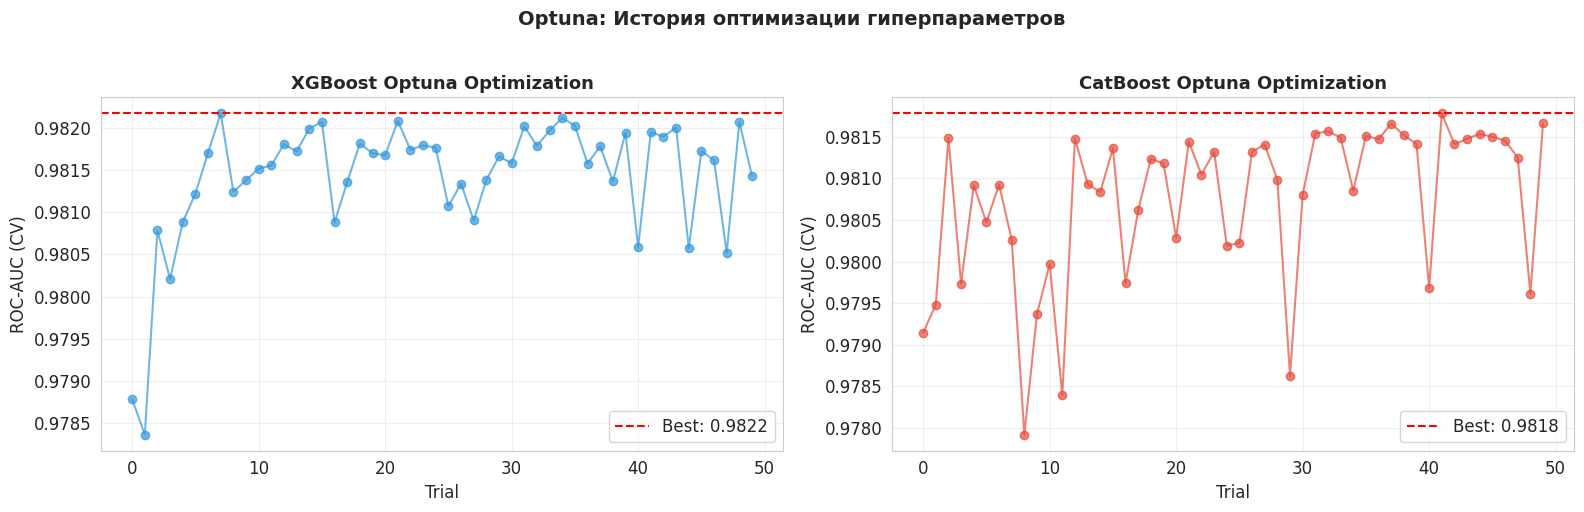

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

xgb_trials = [t.value for t in study_xgb.trials]
axes[0].plot(xgb_trials, 'o-', color='#3498db', alpha=0.7)
axes[0].axhline(y=study_xgb.best_value, color='red', linestyle='--', label=f'Best: {study_xgb.best_value:.4f}')
axes[0].set_title('XGBoost Optuna Optimization', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('ROC-AUC (CV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cb_trials = [t.value for t in study_cb.trials]
axes[1].plot(cb_trials, 'o-', color='#e74c3c', alpha=0.7)
axes[1].axhline(y=study_cb.best_value, color='red', linestyle='--', label=f'Best: {study_cb.best_value:.4f}')
axes[1].set_title('CatBoost Optuna Optimization', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('ROC-AUC (CV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Optuna: История оптимизации гиперпараметров', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [59]:
print("\n Сравнение GridSearchCV vs Optuna:")
print(f"   XGBoost GridSearch ROC-AUC: {benchmark_results.get('XGBoost (tuned)', {}).get('ROC-AUC', 'N/A')}")
print(f"   XGBoost Optuna ROC-AUC:     {benchmark_results.get('XGBoost (Optuna)', {}).get('ROC-AUC', 'N/A')}")
print(f"   CatBoost GridSearch ROC-AUC: {benchmark_results.get('CatBoost (tuned)', {}).get('ROC-AUC', 'N/A')}")
print(f"   CatBoost Optuna ROC-AUC:     {benchmark_results.get('CatBoost (Optuna)', {}).get('ROC-AUC', 'N/A')}")


 Сравнение GridSearchCV vs Optuna:
   XGBoost GridSearch ROC-AUC: 0.9325
   XGBoost Optuna ROC-AUC:     0.9326
   CatBoost GridSearch ROC-AUC: 0.927
   CatBoost Optuna ROC-AUC:     0.9337


## 15. Бенчмарк всех моделей — сводная таблица

In [60]:
bench_data = {
    name: {k: v for k, v in metrics.items() if k not in ['model', 'y_pred', 'y_proba']}
    for name, metrics in benchmark_results.items()
}
bench_df = pd.DataFrame(bench_data).T.sort_values('ROC-AUC', ascending=False)
bench_df.index.name = 'Модель'

print(" СВОДНАЯ ТАБЛИЦА БЕНЧМАРКА ВСЕХ МОДЕЛЕЙ")
print("="*80)
bench_df

 СВОДНАЯ ТАБЛИЦА БЕНЧМАРКА ВСЕХ МОДЕЛЕЙ


,ROC-AUC,Accuracy,Precision,Recall,F1-score,Время (сек)
Модель,,,,,,
CatBoost (Optuna),0.9337,0.8977,0.7690,0.7124,0.7396,2.22
XGBoost (Optuna),0.9326,0.8970,0.7710,0.7042,0.7361,5.32
XGBoost (tuned),0.9325,0.8950,0.7725,0.6879,0.7277,6.88
Gradient Boosting,0.9323,0.8957,0.7618,0.7108,0.7354,7.55
Voting (RF+XGB+CB),0.9322,0.8950,0.7676,0.6961,0.7301,22.27
Voting (tuned RF+XGB+CB+GB),0.9317,0.8950,0.7685,0.6944,0.7296,35.98
CatBoost,0.9310,0.8943,0.7697,0.6879,0.7265,1.99
Stacking (RF+XGB+CB → LR),0.9304,0.8890,0.7276,0.7288,0.7282,6.51
Gradient Boosting (tuned),0.9289,0.8907,0.7601,0.6781,0.7168,16.56


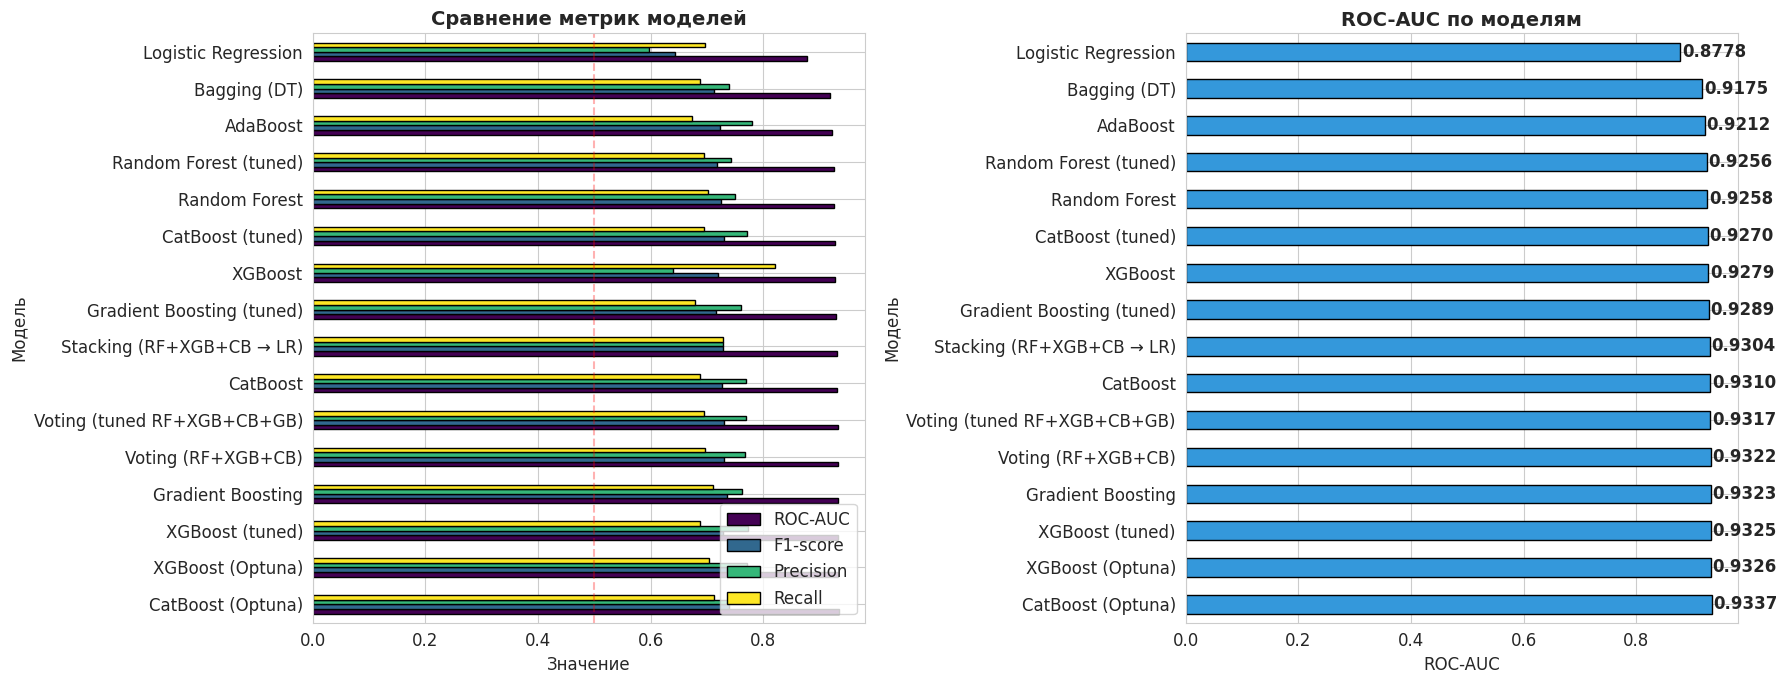

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

metrics_to_plot = ['ROC-AUC', 'F1-score', 'Precision', 'Recall']
bench_df[metrics_to_plot].plot(kind='barh', ax=axes[0], colormap='viridis', edgecolor='black')
axes[0].set_title('Сравнение метрик моделей', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Значение')
axes[0].legend(loc='lower right')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.3)

bench_df['ROC-AUC'].plot(kind='barh', ax=axes[1], color='#3498db', edgecolor='black')
axes[1].set_title('ROC-AUC по моделям', fontsize=14, fontweight='bold')
axes[1].set_xlabel('ROC-AUC')
for i, v in enumerate(bench_df['ROC-AUC']):
    axes[1].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [62]:
best_model_name = bench_df.index[0]
print(f"\n Лучшая модель: {best_model_name}")
print(f"   ROC-AUC: {bench_df.loc[best_model_name, 'ROC-AUC']}")
print(f"   F1-score: {bench_df.loc[best_model_name, 'F1-score']}")


 Лучшая модель: CatBoost (Optuna)
   ROC-AUC: 0.9337
   F1-score: 0.7396


## 16. Кросс-валидация лучших моделей

In [63]:
cv_models = {
    'XGBoost (tuned)': xgb_grid.best_estimator_,
    'Random Forest (tuned)': rf_grid.best_estimator_,
    'CatBoost': CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1,
                                    auto_class_weights='Balanced', verbose=0, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print(" Кросс-валидация (5 фолдов, StratifiedKFold):")
print("="*60)

for name, model in cv_models.items():
    roc_scores = cross_val_score(model, X_train_tree, y_train_tree, cv=skf, scoring='roc_auc', n_jobs=-1)
    f1_scores = cross_val_score(model, X_train_tree, y_train_tree, cv=skf, scoring='f1', n_jobs=-1)
    cv_results[name] = {
        'ROC-AUC (mean)': roc_scores.mean(),
        'ROC-AUC (std)': roc_scores.std(),
        'F1 (mean)': f1_scores.mean(),
        'F1 (std)': f1_scores.std(),
        'roc_scores': roc_scores,
        'f1_scores': f1_scores
    }
    print(f"\n {name}:")
    print(f"   ROC-AUC: {roc_scores.mean():.4f} ± {roc_scores.std():.4f}")
    print(f"   F1:      {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"   Фолды ROC-AUC: {[f'{s:.4f}' for s in roc_scores]}")

 Кросс-валидация (5 фолдов, StratifiedKFold):

 XGBoost (tuned):
   ROC-AUC: 0.9815 ± 0.0016
   F1:      0.9344 ± 0.0036
   Фолды ROC-AUC: ['0.9837', '0.9803', '0.9806', '0.9798', '0.9829']

 Random Forest (tuned):
   ROC-AUC: 0.9801 ± 0.0016
   F1:      0.9328 ± 0.0041
   Фолды ROC-AUC: ['0.9830', '0.9798', '0.9791', '0.9782', '0.9803']

 CatBoost:
   ROC-AUC: 0.9817 ± 0.0016
   F1:      0.9362 ± 0.0033
   Фолды ROC-AUC: ['0.9841', '0.9805', '0.9809', '0.9799', '0.9829']


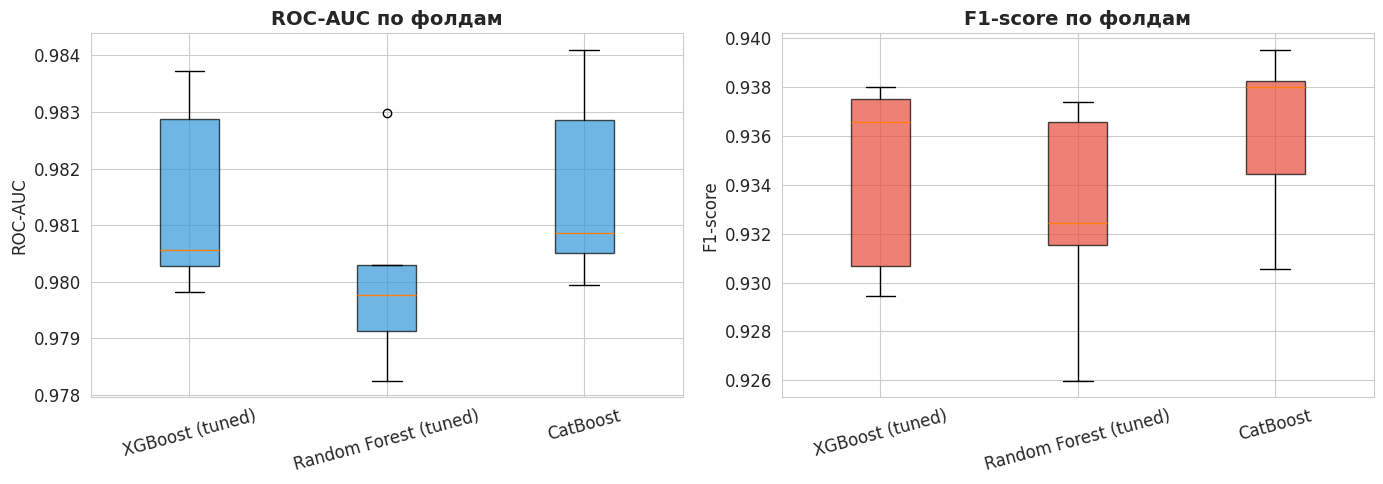

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

roc_data = [cv_results[m]['roc_scores'] for m in cv_results]
f1_data = [cv_results[m]['f1_scores'] for m in cv_results]

axes[0].boxplot(roc_data, labels=list(cv_results.keys()), patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.7))
axes[0].set_title('ROC-AUC по фолдам', fontsize=14, fontweight='bold')
axes[0].set_ylabel('ROC-AUC')
axes[0].tick_params(axis='x', rotation=15)

axes[1].boxplot(f1_data, labels=list(cv_results.keys()), patch_artist=True,
                boxprops=dict(facecolor='#e74c3c', alpha=0.7))
axes[1].set_title('F1-score по фолдам', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## 17. Confusion Matrix и ROC-кривые

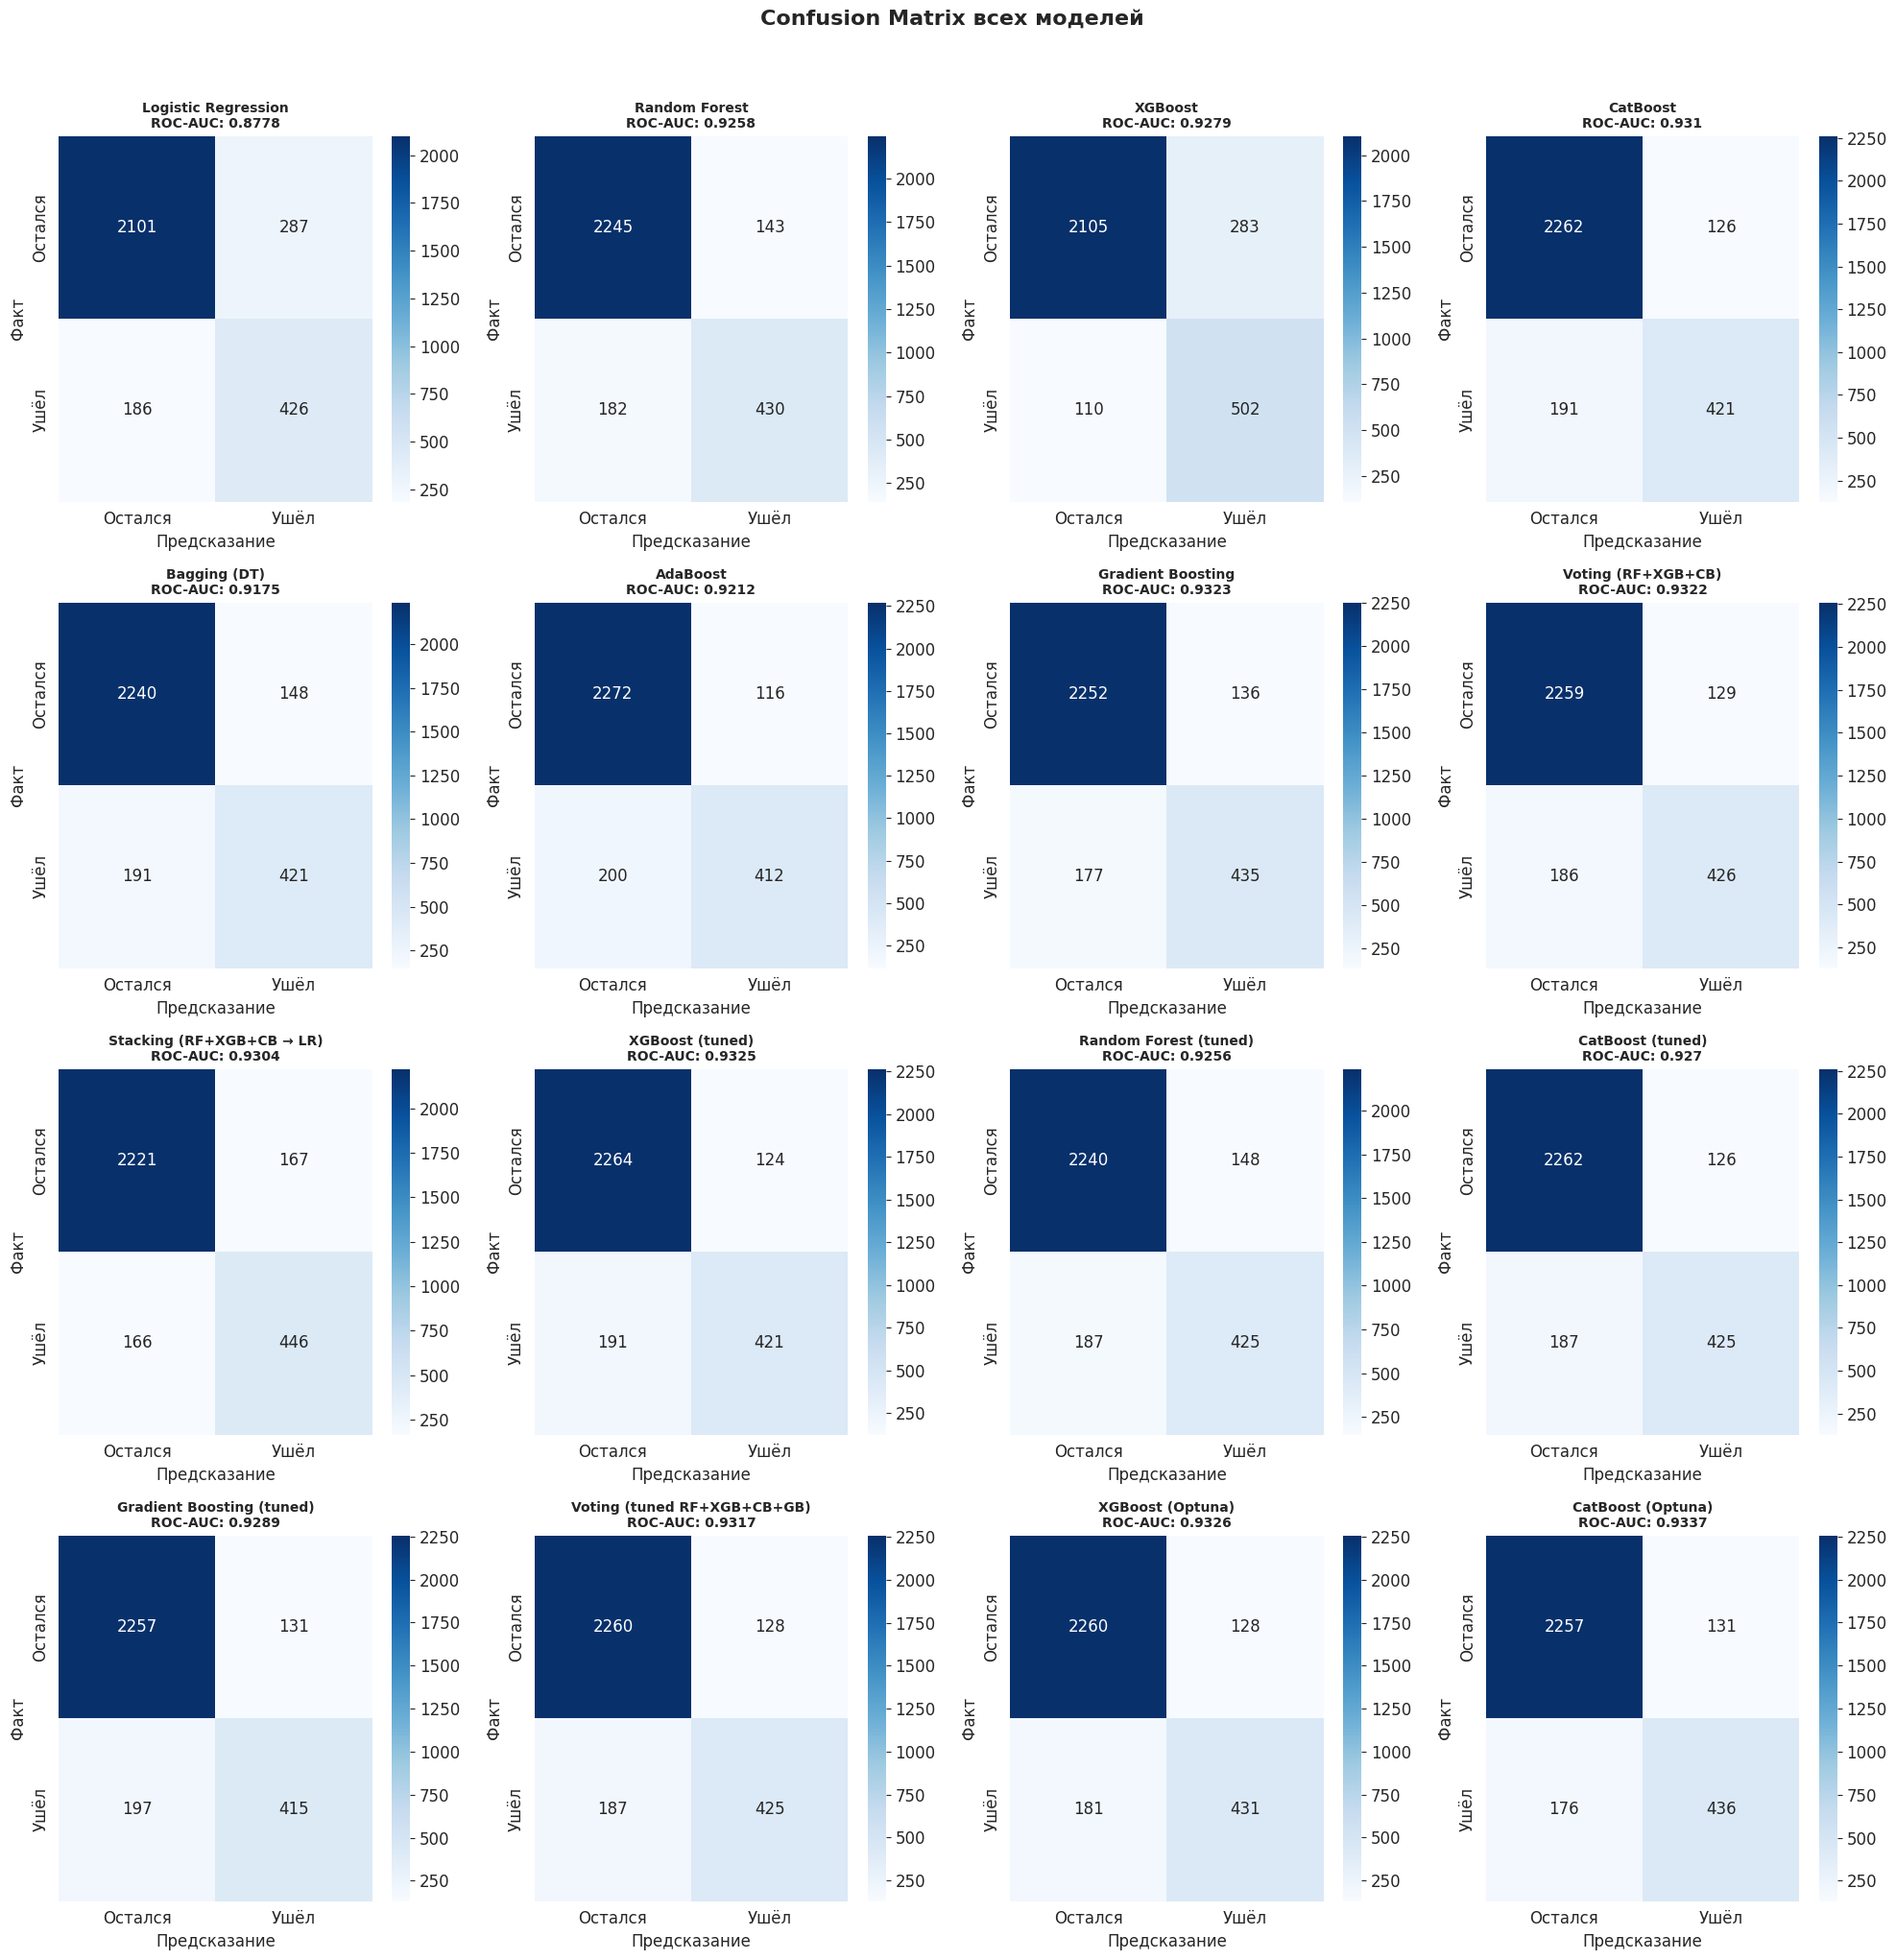

In [65]:
model_names = list(benchmark_results.keys())
n_models = len(model_names)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, name in enumerate(model_names):
    cm = confusion_matrix(y_test, benchmark_results[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Остался', 'Ушёл'], yticklabels=['Остался', 'Ушёл'])
    roc = benchmark_results[name]['ROC-AUC']
    axes[i].set_title(f'{name}\nROC-AUC: {roc}', fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Предсказание')
    axes[i].set_ylabel('Факт')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Confusion Matrix всех моделей', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

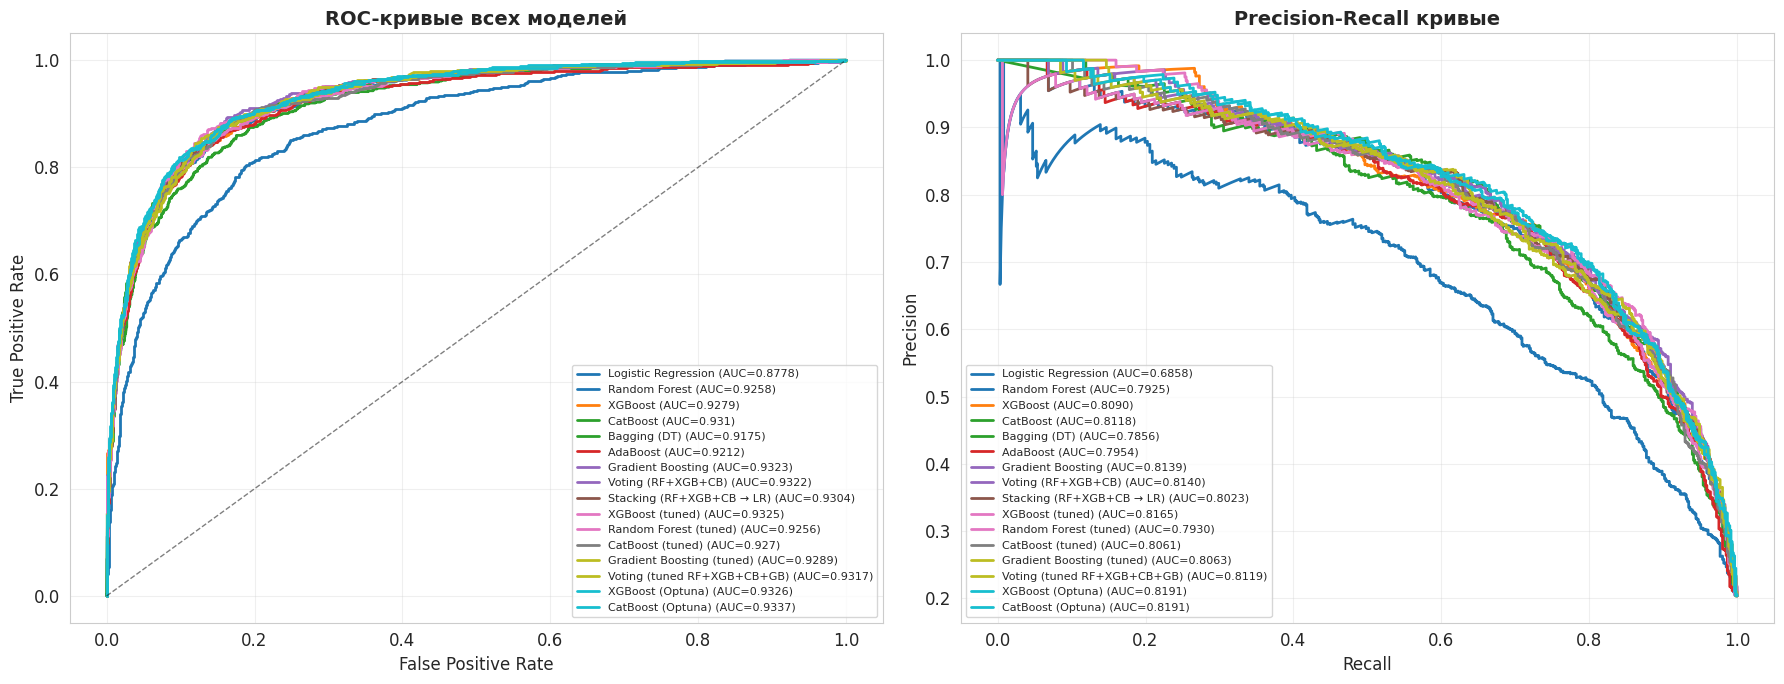

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

colors = plt.cm.tab10(np.linspace(0, 1, len(benchmark_results)))

for idx, (name, metrics) in enumerate(benchmark_results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['y_proba'])
    roc_val = metrics['ROC-AUC']
    axes[0].plot(fpr, tpr, color=colors[idx], lw=2, label=f'{name} (AUC={roc_val})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[0].set_title('ROC-кривые всех моделей', fontsize=14, fontweight='bold')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(fontsize=8, loc='lower right')
axes[0].grid(True, alpha=0.3)

for idx, (name, metrics) in enumerate(benchmark_results.items()):
    prec_vals, rec_vals, _ = precision_recall_curve(y_test, metrics['y_proba'])
    pr_auc = auc(rec_vals, prec_vals)
    axes[1].plot(rec_vals, prec_vals, color=colors[idx], lw=2, label=f'{name} (AUC={pr_auc:.4f})')

axes[1].set_title('Precision-Recall кривые', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(fontsize=8, loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Оценка важности признаков (Feature Importance и SHAP)

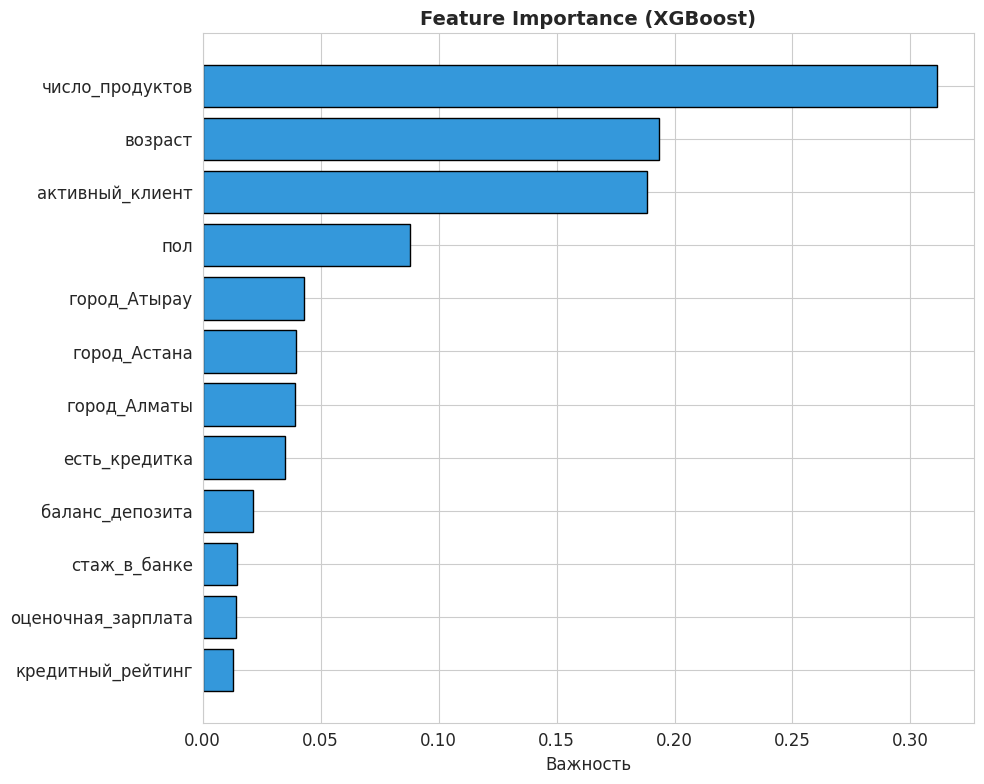

In [67]:
best_tree_model = benchmark_results.get('XGBoost (tuned)', benchmark_results.get('XGBoost'))['model']

importances = best_tree_model.feature_importances_
feat_imp = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importances
}).sort_values('Важность', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feat_imp['Признак'], feat_imp['Важность'], color='#3498db', edgecolor='black')
ax.set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Важность')
plt.tight_layout()
plt.show()

In [68]:
print(" Вычисление SHAP values (может занять некоторое время)...")
explainer = shap.TreeExplainer(best_tree_model)

 Вычисление SHAP values (может занять некоторое время)...



 SHAP Summary Plot:


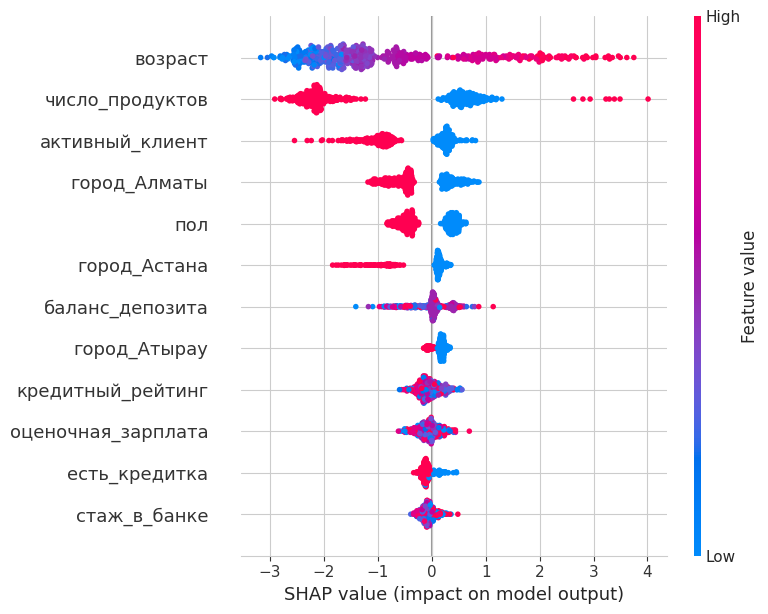


 SHAP Bar Plot (средняя абсолютная важность):


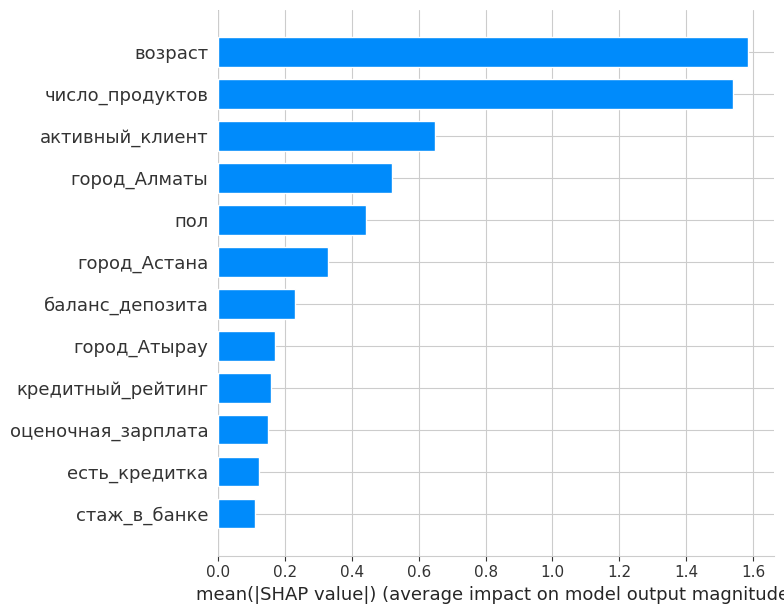

In [69]:
X_test_df = pd.DataFrame(X_test_tree, columns=feature_names)
X_shap = X_test_df.sample(n=min(500, len(X_test_df)), random_state=42)
shap_values = explainer.shap_values(X_shap)

print("\n SHAP Summary Plot:")
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=True)

print("\n SHAP Bar Plot (средняя абсолютная важность):")
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type='bar', show=True)

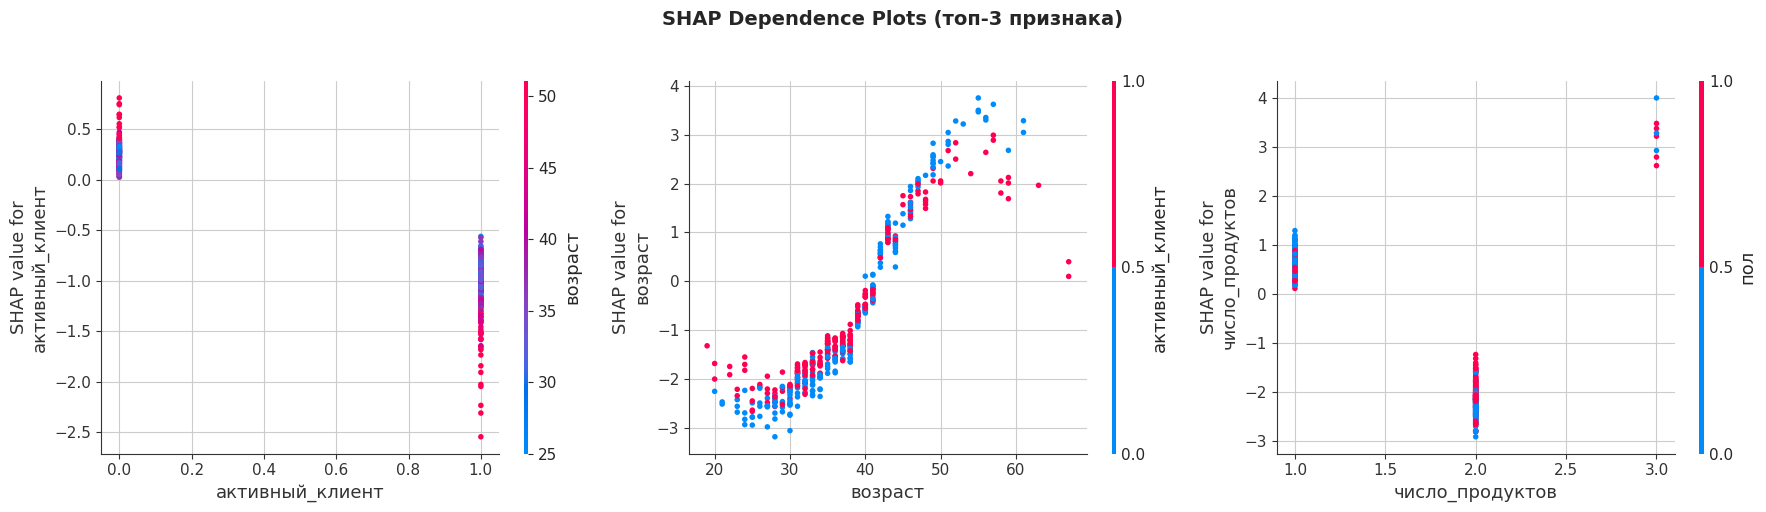


 SHAP Force Plot (пример предсказания):


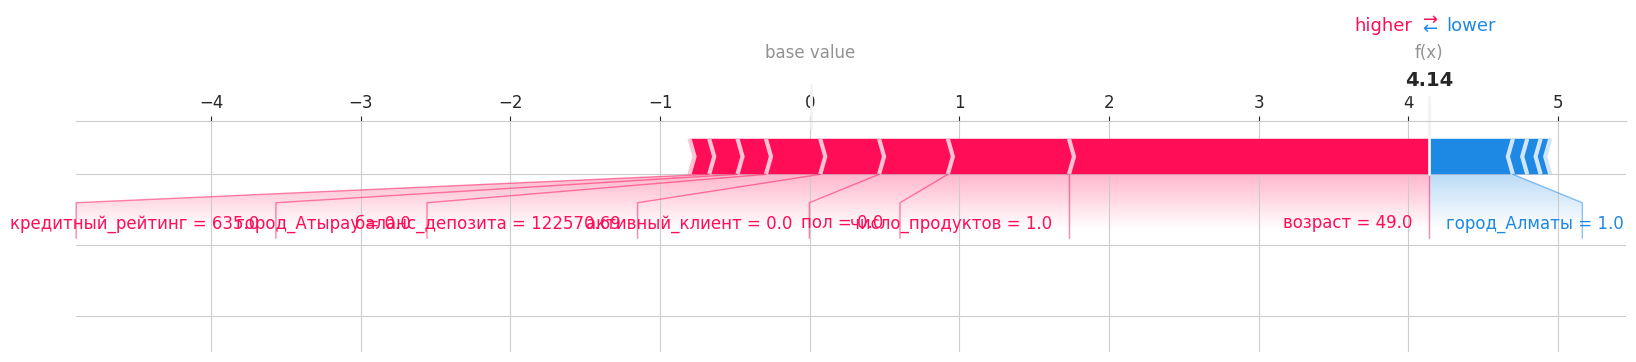

In [70]:
top_features = feat_imp.tail(3)['Признак'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feat in enumerate(top_features):
    shap.dependence_plot(feat, shap_values, X_shap, feature_names=feature_names, ax=axes[i], show=False)
plt.suptitle('SHAP Dependence Plots (топ-3 признака)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n SHAP Force Plot (пример предсказания):")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_shap.iloc[0], feature_names=feature_names, matplotlib=True)
plt.show()

## 19. Сохранение лучшей модели и пайплайна

In [71]:
os.makedirs('models', exist_ok=True)


best_name = bench_df.index[0]
best_model = benchmark_results[best_name]['model']

joblib.dump(best_model, 'models/best_model.pkl')
print(f" Лучшая модель '{best_name}' сохранена в models/best_model.pkl")

 Лучшая модель 'CatBoost (Optuna)' сохранена в models/best_model.pkl


In [72]:
joblib.dump(scaler, 'models/scaler.pkl')
print(f" Scaler сохранён в models/scaler.pkl")

joblib.dump(le_gender, 'models/label_encoder_gender.pkl')
print(f" LabelEncoder (пол) сохранён в models/label_encoder_gender.pkl")

 Scaler сохранён в models/scaler.pkl
 LabelEncoder (пол) сохранён в models/label_encoder_gender.pkl


In [73]:
metadata = {
    'best_model_name': best_name,
    'feature_names': feature_names,
    'metrics': {k: v for k, v in benchmark_results[best_name].items()
                if k not in ['model', 'y_pred', 'y_proba']},
    'cities': ['Алматы', 'Астана', 'Атырау'],
    'gender_mapping': dict(zip(le_gender.classes_.tolist(), le_gender.transform(le_gender.classes_).tolist())),
    'needs_scaling': best_name == 'Logistic Regression',
    'is_ensemble': 'Voting' in best_name or 'Stacking' in best_name
}

if hasattr(best_model, 'estimators_'):
    if isinstance(best_model.estimators_[0], tuple):
        shap_base_model = best_model.estimators_[0][1]  # VotingClassifier
    else:
        shap_base_model = best_model.estimators_[0]  # StackingClassifier
    joblib.dump(shap_base_model, 'models/shap_model.pkl')
    metadata['shap_model_type'] = type(shap_base_model).__name__
    print(f" Базовая модель для SHAP ({type(shap_base_model).__name__}) сохранена в models/shap_model.pkl")

with open('models/metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)
print(f" Метаданные сохранены в models/metadata.json")

 Метаданные сохранены в models/metadata.json


In [74]:
bench_df.to_csv('models/benchmark_results.csv')
print(f" Бенчмарк сохранён в models/benchmark_results.csv")

loaded_model = joblib.load('models/best_model.pkl')
test_pred = loaded_model.predict(X_test_tree[:1])
test_proba = loaded_model.predict_proba(X_test_tree[:1])
print(f"\n Тест загруженной модели:")
print(f"   Предсказание: {test_pred[0]}, Вероятность оттока: {test_proba[0][1]:.4f}")

 Бенчмарк сохранён в models/benchmark_results.csv

 Тест загруженной модели:
   Предсказание: 1, Вероятность оттока: 0.6983
